In [166]:
using NBInclude
@nbinclude("julia_function.ipynb")

allskyevents_free_eres (generic function with 1 method)

In [147]:
using StatProfilerHTML

In [150]:
@profilehtml allskyts_real(10^(-14), 0.5, 7)

[ Info: Wrote profiling output to file:///Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/statprof/index.html .


35.02646035716731

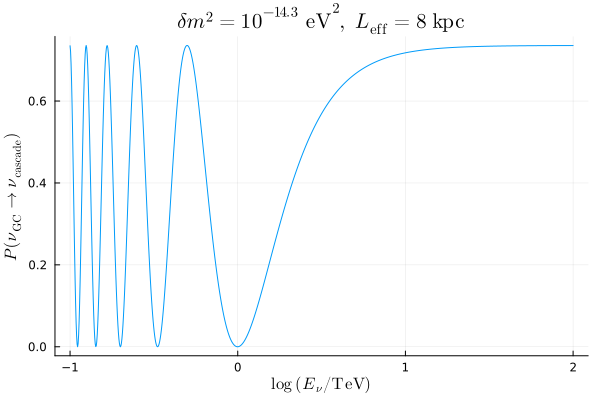

In [2]:
# Checking and plotting the oscillation probabilities

dm2 = 10^(-14.3); leff = 8

logerange = range(-1, 2, 1000)
erange = 10 .^ logerange

pe = osce.(erange, dm2, leff)
pτ = oscτ.(erange, dm2, leff)
pμ = oscμ.(erange, dm2, leff)
ps = @. 1 - pe - pτ - pμ
p_casc = oscprob.(erange, dm2, leff)

plot(
    logerange,
    p_casc,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{\mathrm{GC}} \to \nu_{\mathrm{cascade}})",
    label=false,
    title=L"\delta m^2 = 10^{-14.3}~\mathrm{eV}^2,~L_\mathrm{eff} = 8~\mathrm{kpc}"
)

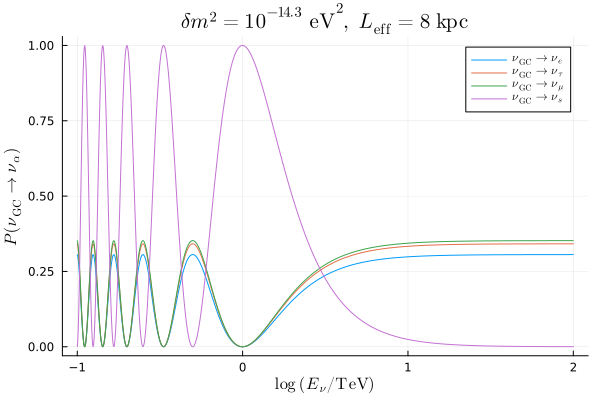

In [3]:

plot(
    logerange,
    [pe pτ pμ ps],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{\mathrm{GC}} \to \nu_{\alpha})",
    label=[L"\nu_{\mathrm{GC}} \to \nu_e" L"\nu_{\mathrm{GC}} \to \nu_{\tau}" L"\nu_{\mathrm{GC}} \to \nu_{\mu}" L"\nu_{\mathrm{GC}} \to \nu_{s}"],
    title=L"\delta m^2 = 10^{-14.3}~\mathrm{eV}^2,~L_\mathrm{eff} = 8~\mathrm{kpc}"
)

In [4]:
# Checking that the total event number is ~748 for just all sky flux

function allskyflux(et, γ)
    ϕ₀ = 21.8e-16 * 3.156e8
    e0 = 100
    flx = ϕ₀ * (et/e0)^(-γ) * effarea(et) * 10000
end

# Log integral with jacobian
function logintegral(γ)
    nsteps = 200
    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = allskyflux.((10 .^ us), γ) .* du .* (10 .^ us) .* log(10)
    int = sum(steps)
end

# True integral without jacobian
function trueintegral(γ)
    nsteps = 100000
    es = range(emin, emax, nsteps)
    de = es[2] - es[1]
    steps = allskyflux.(es, γ) .* de
    int = sum(steps)
end

logint = logintegral(2.7)
trueint = trueintegral(2.7)
println("log integral: $logint \ntrue integral: $trueint")

log integral: 739.4983671347962 
true integral: 738.7058492403846


In [5]:
# Checking that the spatial PDF and energy distribution are independent: number should be a bit higher than expected, but go down
# and approach 748 as sampling density increases

function weightedskyflux(et, γ, l, b, θ)
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    vols = blength .* sbinarea.(rbins, l, b, θ)

    pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

    losint = sum(vols .* pds .* allskyflux(et, γ))
end

function weightedintegral(γ, nb)
    
    function esteps(et, γ, nb)

        bsize = π/nb

        b_range = (-π/2+bsize):bsize:(π/2-bsize)
        l_range = (0+bsize/2):bsize:(2π-bsize/2)

        skybins = []
        for l in l_range
            for b in b_range
                push!(skybins, weightedskyflux(et, γ, l, (-b), bsize))
            end
        end
        return sum(skybins)
    end

    nsteps = 200
    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = esteps.((10 .^ us), γ, nb) .* du .* (10 .^ us) .* log(10)
    int = sum(steps)
end

weightedintegral (generic function with 1 method)

In [7]:
# Good agreement

weightedintegral(2.7, 200)

746.7316962966071

In [261]:
# Checking the energy smearing PDF

dm2 = 10^(-14); l = 0; b = 0; σ = 0.5; ϕ₀ = 21.8; γ = 2.7; θ = 0.122; nsteps = 100

# Mutates emptymat and ur
function fstrippedmat!(emptymat, ur, dm2, l, b, θ, ϕ₀, γ)
    ur .= 10 .^ ur
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)
    for i in 1:length(ur)
        for j in 1:length(rbins)
            vols = blength * oscprob(ur[i], dm2, rbins[j]) * sbinarea(rbins[j], l, b, θ)
            emptymat[j, i] = vols
        end 
    end
    flx = fluxfreeparams1(ur, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
    vec(sum(flx .* emptymat, dims=1)) .* (effarea.(ur) * 10000)
end

# The 0.5's are sorta arbitrary constants that shift the function enough to provide correct results (hehe)
samples = range(-2, log10(emax)+2, length=1000)
de = samples[2]-samples[1]

# Altered PDF from the Galactic plane paper
pdf_func(ur) = @. log(10) * exp10(ur - 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
gsample = pdf_func(samples)
g_fft = fft(gsample)

emptymat = zeros(61, length(samples)) # 61 from the sampling frequency along r
fsample = fstrippedmat!(emptymat, collect(samples), dm2, l, b, θ, ϕ₀, γ)
f_fft = fft(fsample)
C = f_fft .* g_fft
c = real(ifft(C)) .* de

# Again shifting the function to fit with expectation
cut = trunc(Int, (2)/de)
c1 = vcat(c[(cut+1):end], zeros(cut))

fg = Interpolations.interpolate((samples,), c1, Gridded(Linear()))

loges = range(log10(emin), log10(emax), nsteps)

-0.13970910365372904:0.03213197425937285:3.041356348024183

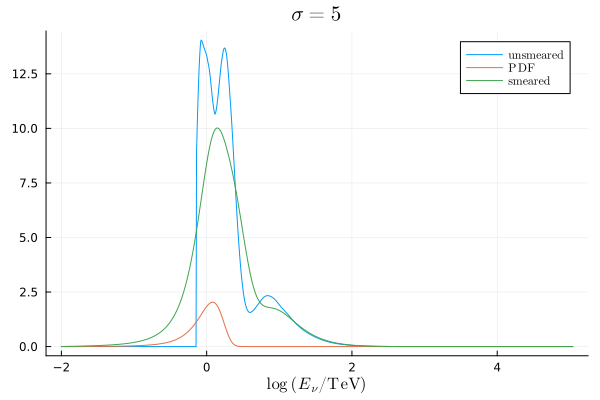

In [262]:
plot(
    samples,
    [fsample gsample fg.(samples)],
    label=[L"\mathrm{unsmeared}" L"\mathrm{PDF}" L"\mathrm{smeared}"],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    title=L"\sigma = 5"
)

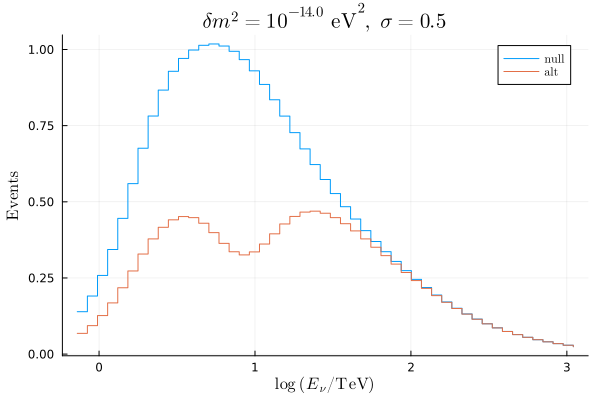

In [217]:
# Checking and plotting the binned smeared event dist

logerange = range(log10(emin), log10(emax), 50)
newedistfunc_alt = edistbinnedfreeparams(10^(-14.0), 0, 0, 1, 0.05, 21.8, 2.7)
newedistfunc_null = edistbinnedfreeparams(0, 0, 0, 1, 0.05, 21.8, 2.7)
plot(
    logerange,
    [newedistfunc_null newedistfunc_alt],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~\sigma = 0.5"
)

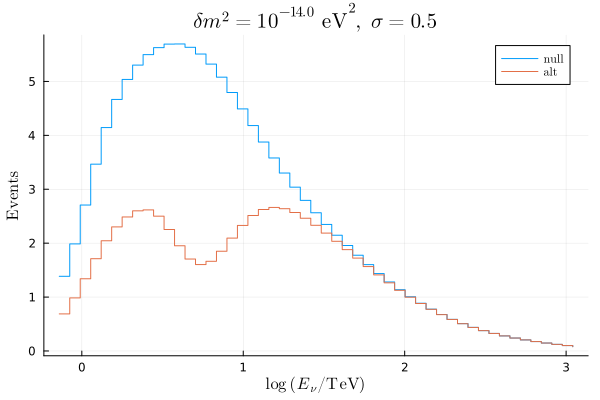

In [7]:
logerange = range(log10(emin), log10(emax), 50)
newedistfunc_alt = edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.122, 21.8, 2.7)
newedistfunc_null = edistbinnedfreeparams(0, 0, 0, 0.5, 0.122, 21.8, 2.7)
plot(
    logerange,
    [newedistfunc_null newedistfunc_alt],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~\sigma = 0.5"
)

In [14]:
testallsky = allskyevents_free_eres(0, 21.8, 2.7, 0.01, 200)

50-element Vector{Float64}:
 14.593680150425179
 20.982966099225678
 23.897575082398298
 26.411048087604406
 28.6790635544245
 30.705569867172496
 32.034160364376675
 33.01929590597084
 34.10466946977892
 34.27854410424247
 34.07259324746208
 34.63555952667029
 33.44997683949937
  ⋮
  2.377928123085071
  2.05126449772472
  1.7446506625947213
  1.5033097449424841
  1.2980639539345076
  1.117097460948124
  0.9513436727176892
  0.8009057664787836
  0.6548319744576132
  0.5600432579205535
  0.4887087266079059
  0.37992626751320535

In [15]:
sum(testallsky)

743.1618576413817

In [16]:
testallsky1 = allskyevents_free_eres(0, 21.8, 2.7, 0.01, 100)

50-element Vector{Float64}:
 15.599705566245332
 22.4294413527277
 25.54497091823636
 28.23171192021583
 30.656074598950646
 32.82227952335315
 34.24245732366577
 35.29550386390154
 36.45569840361119
 36.641559206034685
 36.421410984765345
 37.023185733070804
 35.75587408490058
  ⋮
  2.541852239836916
  2.1926698319522817
  1.8649193604287713
  1.6069414400100506
  1.387546888708885
  1.1941053455994877
  1.0169252055503397
  0.8561167583910883
  0.6999732686758824
  0.5986502265275718
  0.522398200053567
  0.40611674704392653

In [17]:
sum(testallsky) / sum(testallsky1)

0.935509974111498

In [18]:
testallsky1_normalized = testallsky1 * (0.94)


50-element Vector{Float64}:
 14.66372323227061
 21.083674871564035
 24.012272663142177
 26.53780920500288
 28.816710123013607
 30.85294275195196
 32.18790988424582
 33.17777363206744
 34.268356499394514
 34.443065653672605
 34.23612632567942
 34.801794589086555
 33.61052163980655
  ⋮
  2.389341105446701
  2.0611096420351447
  1.7530241988030448
  1.5105249536094474
  1.304294075386352
  1.1224590248635185
  0.9559096932173193
  0.804749752887623
  0.6579748725553294
  0.5627312129359174
  0.49105430805035294
  0.38174974222129093

In [23]:
# Testing the angular smearing

smeared = anglesmear(0, 21.8, 2.7, 0.01, 7, 200)

50-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0;

In [24]:
sum(sum(smeared))

746.0956270764051

In [31]:
# anglesmearbin(dm2, ϕ₀, γ, σ, res, nb)
test_binned = anglesmearbin(0, 21.8, 2.7, 0.5, 7, 100)

25×51 Matrix{Vector{Float64}}:
 [-5.70868e-6, -8.18203e-6, -1.11539e-5, -1.42781e-5, -1.70763e-5, -1.92271e-5, -2.0753e-5, -2.18524e-5, -2.26528e-5, -2.31856e-5  …  -1.55648e-6, -1.34165e-6, -1.154e-6, -9.89357e-7, -8.45027e-7, -7.18249e-7, -6.05645e-7, -5.04142e-7, -4.11511e-7, -3.26025e-7]                       …  [-8.19365e-6, -1.17436e-5, -1.60092e-5, -2.04933e-5, -2.45095e-5, -2.75966e-5, -2.97866e-5, -3.13647e-5, -3.25135e-5, -3.32782e-5  …  -2.23402e-6, -1.92566e-6, -1.65633e-6, -1.42002e-6, -1.21286e-6, -1.0309e-6, -8.69279e-7, -7.23593e-7, -5.90639e-7, -4.67943e-7]
 [-4.55607e-7, -6.53004e-7, -8.9019e-7, -1.13953e-6, -1.36285e-6, -1.53451e-6, -1.65628e-6, -1.74403e-6, -1.80791e-6, -1.85043e-6  …  -1.24222e-7, -1.07076e-7, -9.21e-8, -7.89601e-8, -6.74412e-8, -5.73231e-8, -4.83362e-8, -4.02353e-8, -3.28425e-8, -2.60199e-8]                           [-3.06024e-7, -4.38612e-7, -5.97925e-7, -7.65402e-7, -9.15404e-7, -1.0307e-6, -1.1125e-6, -1.17144e-6, -1.21434e-6, -1.2429e-6  …  -

In [37]:
test_binned_normed = test_binned * 0.94

25×51 Matrix{Vector{Float64}}:
 [-5.36616e-6, -7.69111e-6, -1.04847e-5, -1.34214e-5, -1.60517e-5, -1.80735e-5, -1.95078e-5, -2.05413e-5, -2.12937e-5, -2.17945e-5  …  -1.4631e-6, -1.26115e-6, -1.08476e-6, -9.29996e-7, -7.94326e-7, -6.75154e-7, -5.69306e-7, -4.73894e-7, -3.8682e-7, -3.06464e-7]                        …  [-7.70203e-6, -1.1039e-5, -1.50486e-5, -1.92637e-5, -2.3039e-5, -2.59408e-5, -2.79994e-5, -2.94828e-5, -3.05627e-5, -3.12815e-5  …  -2.09997e-6, -1.81012e-6, -1.55695e-6, -1.33482e-6, -1.14009e-6, -9.69045e-7, -8.17122e-7, -6.80177e-7, -5.55201e-7, -4.39866e-7]
 [-4.28271e-7, -6.13824e-7, -8.36779e-7, -1.07116e-6, -1.28108e-6, -1.44244e-6, -1.55691e-6, -1.63939e-6, -1.69944e-6, -1.7394e-6  …  -1.16769e-7, -1.00652e-7, -8.6574e-8, -7.42225e-8, -6.33947e-8, -5.38837e-8, -4.5436e-8, -3.78212e-8, -3.08719e-8, -2.44587e-8]                            [-2.87662e-7, -4.12295e-7, -5.6205e-7, -7.19478e-7, -8.60479e-7, -9.68859e-7, -1.04575e-6, -1.10115e-6, -1.14148e-6, -1.16833e-6 

In [38]:
size(test_binned_normed)

(25, 51)

In [46]:
logdm2s = range(-16, -12, 21)
dm2s = 10 .^ logdm2s

real_tss = allskyts_real.(dm2s, 0.5, 7)

21-element Vector{Float64}:
   0.00014874458527375315
 -Inf
   0.005886587510373194
   0.03690844694036563
   0.22897111332162867
   1.3808614573885847
   7.622175492253484
  30.16868199209868
  44.009269289512915
  36.55422697278426
  34.76975015459449
  35.326153746794716
  33.56769933962906
  29.70855532957174
  24.59633863917074
  18.882463461911037
  13.039585790415366
   8.165105662437565
   4.501353494547002
   2.2248577468359523
   0.9878972230717395

In [117]:
allskytss = [
  1.3808614573885847
  7.622175492253484
 30.16868199209868
 44.009269289512915
 36.55422697278426
 34.76975015459449
 35.326153746794716
 33.56769933962906
 29.70855532957174
 24.59633863917074
 18.882463461911037
 13.039585790415366
  8.165105662437565
  4.501353494547002
  2.2248577468359523
  0.9878972230717395]

16-element Vector{Float64}:
  1.3808614573885847
  7.622175492253484
 30.16868199209868
 44.009269289512915
 36.55422697278426
 34.76975015459449
 35.326153746794716
 33.56769933962906
 29.70855532957174
 24.59633863917074
 18.882463461911037
 13.039585790415366
  8.165105662437565
  4.501353494547002
  2.2248577468359523
  0.9878972230717395

In [131]:
oldtss = vec(readdlm("misc_data/all_sky_test_stats_2.txt"))

31-element Vector{Float64}:
  0.7967867700703855
  1.9097583150525836
  4.4159637503044
  9.517989503610798
 17.797966241904568
 25.388381181521943
 24.738379504915372
 19.915921120932516
 17.709852272656768
 17.161132638444577
 17.829434913069385
 18.760122478507554
 19.506294644208225
  ⋮
 11.819639523944137
  9.934510763309742
  7.9909028182606825
  6.4783049397964225
  4.734852821783676
  3.511387050459596
  2.4040022664767644
  1.5851496699416516
  0.9041423566653457
  0.6063631161929723
  0.39144625200449235
  0.27425629529086337

In [125]:
inc_sampling_logdm2 = collect(range(-15, -12, 31))

newtss_interp = Interpolations.interpolate((logdm2s,), allskytss, Gridded(Linear()))

16-element interpolate((-15.0:0.2:-12.0,), ::Vector{Float64}, Gridded(Linear())) with element type Float64:
  1.3808614573885847
  7.622175492253484
 30.16868199209868
 44.009269289512915
 36.55422697278426
 34.76975015459449
 35.326153746794716
 33.56769933962906
 29.70855532957174
 24.59633863917074
 18.882463461911037
 13.039585790415366
  8.165105662437565
  4.501353494547002
  2.2248577468359523
  0.9878972230717395

In [118]:
logdm2s = range(-15, -12, 16)
collect(logdm2s)

16-element Vector{Float64}:
 -15.0
 -14.8
 -14.6
 -14.4
 -14.2
 -14.0
 -13.8
 -13.6
 -13.4
 -13.2
 -13.0
 -12.8
 -12.6
 -12.4
 -12.2
 -12.0

In [132]:
newtss = newtss_interp.(inc_sampling_logdm2)

31-element Vector{Float64}:
  1.3808614573885847
  4.501518474821034
  7.622175492253484
 18.895428742176183
 30.16868199209868
 37.0889756408058
 44.009269289512915
 40.28174813114862
 36.55422697278426
 35.66198856368938
 34.76975015459449
 35.0479519506946
 35.326153746794716
  ⋮
 21.739401050540888
 18.882463461911037
 15.961024626163201
 13.039585790415366
 10.602345726426444
  8.165105662437565
  6.333229578492284
  4.501353494547002
  3.3631056206914876
  2.2248577468359523
  1.606377484953846
  0.9878972230717395

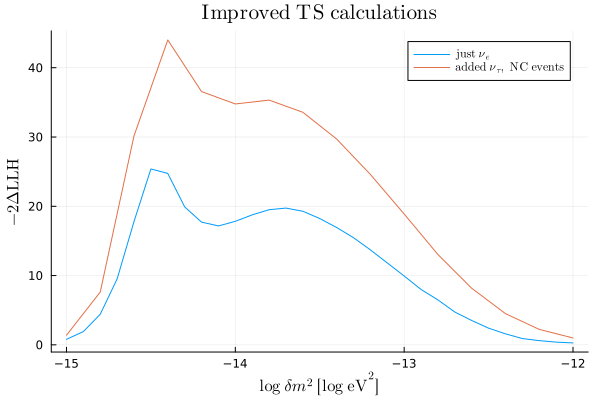

In [137]:
plot(
    inc_sampling_logdm2,
    [oldtss newtss],
    xlabel=L"\log~\delta m^2~[\log~\mathrm{eV}^2]",
    ylabel=L"-2 \Delta \mathrm{LLH}",
    title=L"\mathrm{Improved~TS~calculations}",
    label=[L"\mathrm{just~} \nu_e" L"\mathrm{added~} \nu_{\tau},~\mathrm{NC~events}"]
)

In [32]:
@time anglesmearbin(0, 21.8, 2.7, 0.5, 7, 100)

 69.331508 seconds (6.10 M allocations: 16.053 GiB, 4.88% gc time)


25×51 Matrix{Vector{Float64}}:
 [-5.70868e-6, -8.18203e-6, -1.11539e-5, -1.42781e-5, -1.70763e-5, -1.92271e-5, -2.0753e-5, -2.18524e-5, -2.26528e-5, -2.31856e-5  …  -1.55648e-6, -1.34165e-6, -1.154e-6, -9.89357e-7, -8.45027e-7, -7.18249e-7, -6.05645e-7, -5.04142e-7, -4.11511e-7, -3.26025e-7]                       …  [-8.19365e-6, -1.17436e-5, -1.60092e-5, -2.04933e-5, -2.45095e-5, -2.75966e-5, -2.97866e-5, -3.13647e-5, -3.25135e-5, -3.32782e-5  …  -2.23402e-6, -1.92566e-6, -1.65633e-6, -1.42002e-6, -1.21286e-6, -1.0309e-6, -8.69279e-7, -7.23593e-7, -5.90639e-7, -4.67943e-7]
 [-4.55607e-7, -6.53004e-7, -8.9019e-7, -1.13953e-6, -1.36285e-6, -1.53451e-6, -1.65628e-6, -1.74403e-6, -1.80791e-6, -1.85043e-6  …  -1.24222e-7, -1.07076e-7, -9.21e-8, -7.89601e-8, -6.74412e-8, -5.73231e-8, -4.83362e-8, -4.02353e-8, -3.28425e-8, -2.60199e-8]                           [-3.06024e-7, -4.38612e-7, -5.97925e-7, -7.65402e-7, -9.15404e-7, -1.0307e-6, -1.1125e-6, -1.17144e-6, -1.21434e-6, -1.2429e-6  …  -

In [141]:
function allskynllh_test(dm2, ϕ₀, γ, σ, res)

    res_rad = res * (π/180)

    sumllh = 0

    # This sampling gets the majority of events and gives an *almost* maximized parameter set
    for lval in (-pi/2):res_rad:(pi/2)
        for bval in (-0.122):res_rad:(0.122)
            sumllh += negloglh2(dm2, lval, bval, σ, res_rad, ϕ₀, γ)
        end
    end
    
    return sumllh
end

function allskymaxlh_test_LBFGS(dm2, σ, res)

    function nllh(test)
        return allskynllh_test(dm2, test[1], test[2], σ, res)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, LBFGS())
end

function allskymaxlh_test_NelderMead(dm2, σ, res)

    function nllh(test)
        return allskynllh_test(dm2, test[1], test[2], σ, res)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

allskymaxlh_test_NelderMead (generic function with 1 method)

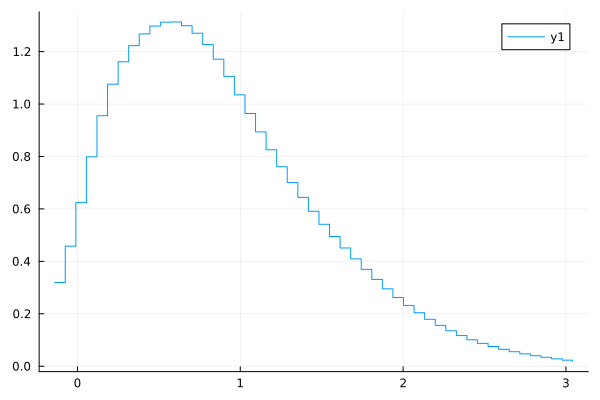

In [29]:
plot(
    range(log10(emin), log10(emax), 50),
    smeared_binned_edist[13, 26],
    seriestype=:step
)

In [145]:
maxlh_test_null = Optim.minimum(allskymaxlh_test_NelderMead(0, 0.5, 7))

1180.9936430885862

In [142]:
maxlh_test_03 = Optim.minimum(allskymaxlh_test_NelderMead(10^(-14.4), 0.5, 3))
maxlh_test_07 = Optim.minimum(allskymaxlh_test_NelderMead(10^(-14.4), 0.5, 7))
maxlh_test_12 = Optim.minimum(allskymaxlh_test_NelderMead(10^(-14.4), 0.5, 12))

265.81377942908387

In [143]:
maxlh_test_03

1593.749947817503

In [144]:
maxlh_test_07

1228.2425410473709

In [154]:
function maxlh_allskyevents(dm2, σ)
    mxlhallsky = allskymaxlh(dm2, σ, 1.8)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    nb = 100
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = edistbinnedfreeparams(dm2, l, (-b), σ, bsize, allskymaxparams[1], allskymaxparams[2])
            end
        end
    end

    return sum(skybins)
end

maxlh_allskyevents (generic function with 1 method)

In [98]:
eress = range(0.1, 1, 10)
angres7 = 7
ts_angres7 = allskyts_real.(10^(-14.4), eress, angres7)

10-element Vector{Float64}:
 66.85031077890595
 59.25650537411275
 52.15607729304867
 47.14381718403644
 44.009269289512915
 42.16850931722672
 41.17283998446409
 40.73726850899813
 40.68174226732235
 40.89262387099196

In [241]:
eress = range(0.1, 1, 10)
eventss = maxlh_allskyevents.(10^(-14.0), eress)

10-element Vector{Vector{Float64}}:
 [15.415141745722966, 27.335200765932722, 31.0628258768173, 33.084026777636346, 36.13518338333017, 38.67749093367464, 37.64600190342151, 33.05348661262752, 27.571252526938732, 23.618837592594033  …  1.38301642809003, 1.1476474556193617, 0.956876107277834, 0.7956133065165388, 0.6565145182918756, 0.5343984551682348, 0.4289654399407722, 0.3497561977551815, 0.2862786392724057, 0.193445535489992]
 [13.784148884964402, 22.920195386463945, 29.67119243073029, 33.09559356704882, 35.301861222092064, 36.75716196510024, 36.3141691609335, 33.437424548358244, 29.28511830722254, 25.781330622036414  …  1.4323297265019552, 1.188267245709036, 0.9865716061248726, 0.818862832429043, 0.6760661035912512, 0.5529487547554428, 0.44741592986629486, 0.3581010548055352, 0.27859443958339786, 0.19566040089099626]
 [12.582926295318437, 19.467975070342497, 26.317589959545906, 31.254286796795757, 33.94450036288583, 35.19802637528433, 35.23930325645212, 33.77123913034778, 31.02627251

In [242]:
writedlm("misc_data/total_allsky_events_140_diff_eres.txt", eventss)

In [168]:
eventss_null = allskyevents.(0, eress, 21.8, 2.7, 100)

10-element Vector{Vector{Float64}}:
 [11.508279760122715, 21.11894262619538, 25.49423726175278, 28.303496302867917, 30.77754782078816, 32.95168675218605, 34.51068640471847, 35.69930933820625, 36.69872963865293, 37.08137242381858  …  1.9393954372721547, 1.6649680678589838, 1.4360026407009174, 1.2349997639589176, 1.053981969641245, 0.8872428022114623, 0.7367455096866324, 0.6217286321701219, 0.5257674055218858, 0.36468693374124656]
 [10.57298681764252, 17.95416706567098, 24.001406900545007, 27.706381115862563, 30.283515661585497, 32.40643759650946, 34.10922262105391, 35.381050605490174, 36.287625851594996, 36.81355186476528  …  2.0028469611960262, 1.7193693531321061, 1.4772323685463074, 1.268487012972332, 1.0832159728339879, 0.9162470199038, 0.7666665081515391, 0.6341089582335249, 0.508306044577804, 0.36577241884021816]
 [9.886920658340106, 15.492789899573497, 21.37356039747735, 26.110390328206147, 29.328252606320167, 31.61209053390077, 33.398889483389986, 34.77128198036291, 35.7369767680

In [243]:
eventss_alt = allskyevents.(10^(-14.0), eress, 21.8, 2.7, 100)

10-element Vector{Vector{Float64}}:
 [5.68770394781344, 10.291106943652856, 12.05987027065665, 13.291999800410299, 15.022057945043766, 16.610796166443393, 16.690484088400698, 15.137896754114282, 13.060545395764601, 11.591931869301478  …  1.9388464727117172, 1.6646170076277138, 1.435776822214117, 1.2348547933433782, 1.0538895356684206, 0.8871846255342938, 0.7367094628564117, 0.621706045071663, 0.5257530367978172, 0.3646790365245045]
 [5.154943019671462, 8.687885939866693, 11.500150595027815, 13.220472056500883, 14.569036932959463, 15.651008940135245, 15.93525963815654, 15.13635805210379, 13.71632542523465, 12.54141531943264  …  2.0022000776426707, 1.718955050398215, 1.4769669987264011, 1.2683167902682069, 1.0831071531045642, 0.916178040812454, 0.7666232442431292, 0.634082055827854, 0.508289516251095, 0.365762887474785]
 [4.781265298562392, 7.465086599477569, 10.2443929483378, 12.438758980798145, 13.892251348023333, 14.843745556752701, 15.311600948599308, 15.1306456591461, 14.37670575387

In [244]:
sum_eventss = zeros(10)
for i in 1:length(eventss)
    sum_eventss[i] = sum(eventss[i])
end

sum_eventss_null = zeros(10)
for i in 1:length(eventss_null)
    sum_eventss_null[i] = sum(eventss_null[i])
end

sum_eventss_alt = zeros(10)
for i in 1:length(eventss_alt)
    sum_eventss_alt[i] = sum(eventss_alt[i])
end

In [170]:
sum_eventss_null

10-element Vector{Float64}:
 801.659238844918
 796.7998317557582
 792.1941011997747
 789.4768382625218
 790.543847687167
 796.1671943464571
 806.0834482379319
 819.6371898634793
 836.14335758985
 855.0113657213155

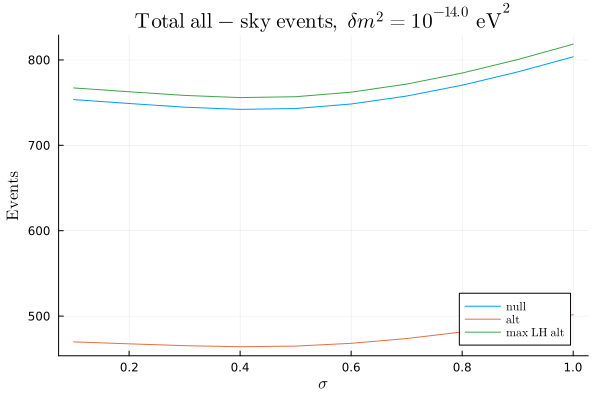

In [245]:
plot(
    eress,
    [sum_eventss_null*0.94 sum_eventss_alt*0.94 sum_eventss*0.94],
    xlabel=L"\sigma",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{max~LH~alt}"],
    title=L"\mathrm{Total~all-sky~events},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"
)

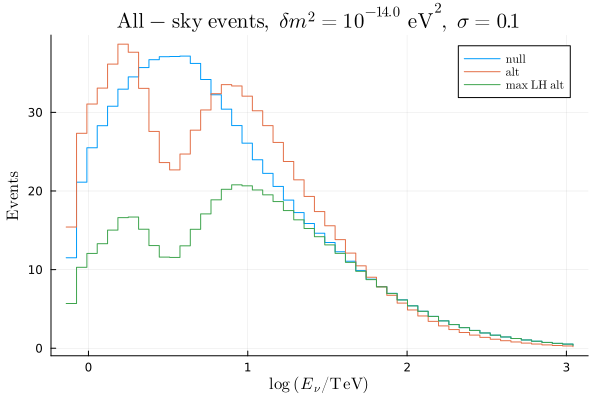

In [254]:
ebins = range(log10(emin), log10(emax), 50)
plot(
    ebins,
    [eventss_null[1] eventss[1] eventss_alt[1]],
    seriestype=:step,
    title=L"\mathrm{All-sky~events},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~\sigma = 0.1",
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{max~LH~alt}"]
)

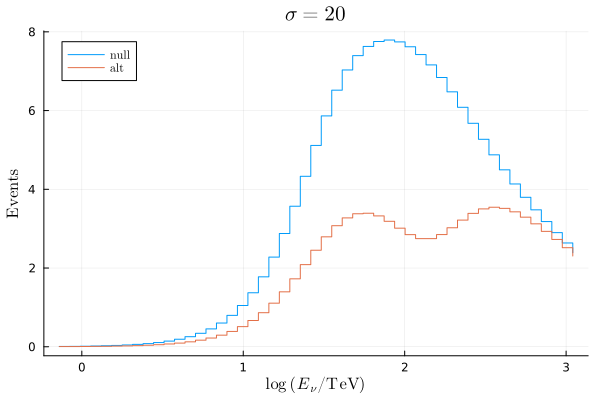

In [228]:
plot(
    ebins,
    [edistbinnedfreeparams(0, 0, 0, 20, 0.05, 21.8, 2.7) edistbinnedfreeparams(10^(-14), 0, 0, 20, 0.05, 21.8, 2.7)],
    seriestype=:step,
    title=L"\sigma = 20",
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{max~LH~alt}"]
)

In [84]:
for i in 1:length(ts_angres7)
    if ts_angres7[i] < 0
        ts_angres7[i] = 0
    end
end

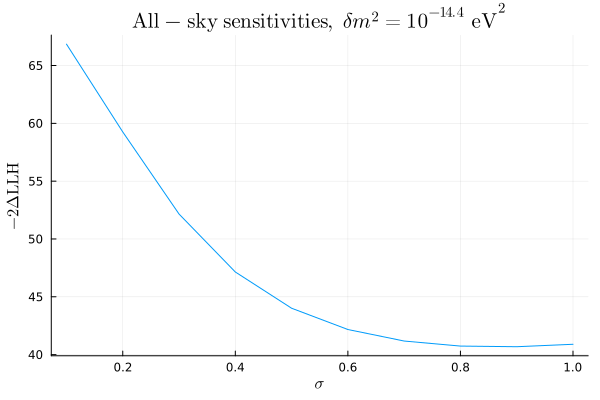

In [102]:
plot(
    eress,
    ts_angres7,
    xlabel=L"\sigma",
    ylabel=L"-2 \Delta \mathrm{LLH}",
    label=false,
    title=L"\mathrm{All-sky~sensitivities},~\delta m^2 = 10^{-14.4}~\mathrm{eV}^2"
)

In [103]:
# savefig("misc_plots/updated_allsky_sensitivities_varying_sigma_7_angres.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/updated_allsky_sensitivities_varying_sigma_7_angres.png"

In [86]:
allskyts_real(10^(-14.4), 0.3, 7)

-Inf

In [87]:
maxlh03 = allskymaxlh(10^(-14.4), 0.3, 7)
maxlh03params = Optim.minimizer(maxlh03)

2-element Vector{Float64}:
 14.781841238578064
  2.97549040327051

In [89]:
function allskyts_real_test2(dm2, σ, θres)

    mxlhallsky = allskymaxlh(dm2, σ, θres)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents_null = anglesmearbin(0, 21.8, 2.7, σ, θres, 100) * 0.94
    askyevents_alt_maxlh = anglesmearbin(dm2, allskymaxparams[1], allskymaxparams[2], σ, θres, 100) * 0.94

    bsize, lsize = size(askyevents_null)
    ts_vals = zeros(bsize, lsize)

    for j in 1:lsize
        for i in 1:bsize
            ts_vals[i, j] = lrt(askyevents_null[i, j], askyevents_alt_maxlh[i, j])
        end
    end
    
    return ts_vals
end

allskyts_real_test2 (generic function with 1 method)

In [139]:
tss_03 = allskyts_real_test2(10^(-14.4), 0.5, 3)

60×120 Matrix{Float64}:
 -0.0          -0.0          -0.0          …  -0.0          -0.0
 -0.0          -0.0          -0.0             -0.0          -0.0
  6.55536e-10   1.44865e-9   -0.0              3.62315e-11   1.32561e-9
 -0.0           2.51823e-10   2.78622e-11      9.06555e-11  -0.0
  7.15981e-11  -0.0           7.82925e-11     -0.0           1.10497e-10
 -0.0          -0.0           1.9019e-11   …  -0.0           2.81613e-11
 -0.0           5.25469e-11  -0.0             -0.0           1.9589e-10
  9.78551e-13  -0.0           2.56573e-12     -0.0          -0.0
 -0.0           6.24389e-13   4.37317e-12      6.8856e-13   -0.0
  3.32623e-13  -0.0           2.44205e-12      1.14828e-11   1.31783e-12
  1.00009e-12  -0.0          -0.0          …  -0.0           1.18927e-12
  1.82965e-13  -0.0          -0.0              7.77156e-14   1.66533e-13
  1.40332e-13  -0.0           1.03029e-13      7.90479e-14   6.66134e-15
  ⋮                                        ⋱                
  1.7497

In [140]:
sum(sum(tss_03))

42.73121947252927

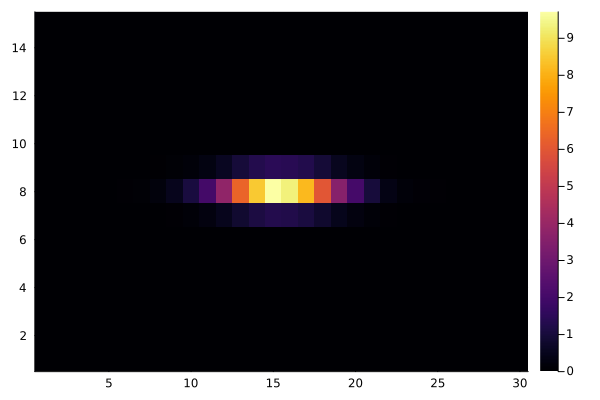

In [108]:
heatmap(tss_03)

In [104]:
angres12 = 12
ts_angres12 = allskyts_real.(10^(-14.4), eress, angres12)

10-element Vector{Float64}:
 107.76220860569492
  99.45201369059312
  90.6993879735885
  84.20910872539014
  80.24078046202034
  78.14410438156696
  77.32547711788979
  77.36083667641378
  77.988511082853
  79.04090462088348

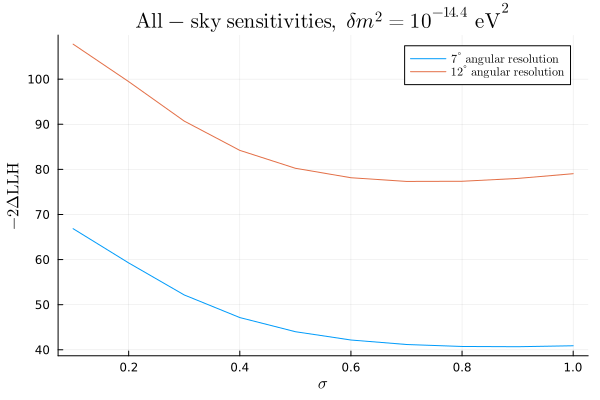

In [111]:
plot(
    eress,
    [ts_angres7 ts_angres12],
    xlabel=L"\sigma",
    ylabel=L"-2 \Delta \mathrm{LLH}",
    label=[L"7^{\circ}~\mathrm{angular~resolution}" L"12^{\circ}~\mathrm{angular~resolution}"],
    title=L"\mathrm{All-sky~sensitivities},~\delta m^2 = 10^{-14.4}~\mathrm{eV}^2"
)

In [112]:
savefig("misc_plots/updated_allsky_sensitivities_varying_sigma_7_12_angres.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/updated_allsky_sensitivities_varying_sigma_7_12_angres.png"